In [0]:
from google.colab import files
uploaded = files.upload()


Saving speaker1.mp3 to speaker1 (1).mp3
Saving speaker2.mp3 to speaker2 (1).mp3


In [0]:
!pip install pydub

In [0]:
import subprocess
from pydub import silence
from pydub import AudioSegment
from wave import open as open_wave
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import librosa
from librosa import display
import glob
import math
import random
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
import time
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras import backend as K
from keras import regularizers


In [0]:
!mkdir wavspeaker
!mkdir dataset
!mkdir dataset/s1
!mkdir dataset/s2

mkdir: cannot create directory ‘wavspeaker’: File exists
mkdir: cannot create directory ‘dataset’: File exists
mkdir: cannot create directory ‘dataset/s1’: File exists
mkdir: cannot create directory ‘dataset/s2’: File exists


In [0]:
subprocess.call(['ffmpeg', '-i', './speaker1.mp3',
                   './wavspeaker/speaker1.wav'])

1

In [0]:
subprocess.call(['ffmpeg', '-i', './speaker2.mp3',
                   './wavspeaker/speaker2.wav'])

1

In [0]:
total_length = 300000
segment_length = 3000
segments = total_length/segment_length
segments = int(segments)

In [0]:
def preprocess_audio_mel(audio, sample_rate=16000, window_size=25,step_size=10, eps=1e-10):
  
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels= 128)
    mel_db = (librosa.power_to_db(mel_spec, ref=np.max))
    return mel_db

In [0]:
for i in range(0,1):
    t1 = 0
    i=0
    newAudio = AudioSegment.from_wav('./wavspeaker/speaker1.wav')
    for i in range(0,segments): 
        newAudio1 = newAudio[t1:(t1+segment_length)]
        newAudio1.export('./dataset/s2/{}.wav'.format(i), format="wav")
        t1 = t1 + segment_length
for i in range(0,1):
    t1 = 0
    i=0
    newAudio = AudioSegment.from_wav('./wavspeaker/speaker1.wav')
    for i in range(0,segments): 
        newAudio1 = newAudio[t1:(t1+segment_length)]
        newAudio1.export('./dataset/s1/{}.wav'.format(i), format="wav")
        t1 = t1 + segment_length

In [0]:
dataset = glob.glob('./dataset/s1/*.wav')
data1 = []
for i in range(0,segments):
    y, sr = librosa.load(dataset[i], sr=16000)
    y = preprocess_audio_mel(audio = y)
    data1.append(y)

In [0]:
dataset = glob.glob('./dataset/s2/*.wav')
data2 = []
for i in range(0,segments):
    y, sr = librosa.load(dataset[i], sr=16000)
    y = preprocess_audio_mel(audio = y)
    data2.append(y)

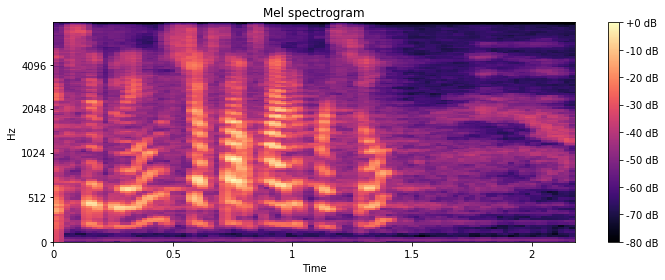

In [0]:
plt.figure(figsize=(10, 4))
display.specshow(data1[0],y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [0]:
data1 = np.array(data1)
data2 = np.array(data2)

In [0]:
data1 = np.expand_dims(data1, axis=3)
data2 = np.expand_dims(data2, axis=3)

In [0]:
data1.shape

(100, 128, 94, 1)

In [0]:
pair1 = []
pair11 =[]
pair0 = []
pair01 = []

In [0]:
for i in range(50):
    indx = np.random.randint(0, 100)
    indx1 = np.random.randint(0, 100)
    pair1.append(data1[indx])
    pair11.append(data1[indx1])

In [0]:
for i in range(100):
    indx = np.random.randint(0, 100)
    indx1 = np.random.randint(0, 100)
    pair0.append(data1[indx])
    pair01.append(data2[indx1])

In [0]:
for i in range(50, 100):
    indx = np.random.randint(0, 100)
    indx1 = np.random.randint(0, 100)
    pair1.append(data2[indx])
    pair11.append(data2[indx1])

In [0]:
label1 = [1]*100
label0 = [0]*100

In [0]:
lside = pair1 + pair0
rside = pair11 + pair01
labels = label1 + label0

In [0]:
labels = np.array(labels)

In [0]:
X_l = np.array(lside)
X_r = np.array(rside)

In [0]:
X_r.shape

(200, 128, 94, 1)

In [0]:
def get_siamese_model(input_shape):
    
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    BATCH_NORM = 1
    model.add(Conv2D(8, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', input_shape=(128,94,1), name='block1_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(8, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block1_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block2_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block2_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block3_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block3_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block3_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block3_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block4_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block4_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block4_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block4_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block5_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block5_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block5_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block5_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Flatten())

    model.add(Dense(2048))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(2048, name='fc2'))
    
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net

In [0]:
model = get_siamese_model((128,94,1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 94, 1)   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 128, 94, 1)   0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 2048)         30173528    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 2048)         0           sequential_3[1][0]               
          

In [0]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])

In [0]:

# Train the discriminator
d_loss = model.fit([X_l, X_r],labels,validation_split=0.33,nb_epoch=1500,verbose=1,shuffle=True)

print( d_loss)

Train on 134 samples, validate on 66 samples
Epoch 1/1500
 32/134 [======>.......................] - ETA: 0s - loss: 14.1104 - acc: 1.0000

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


134/134 [==============================] - 1s 6ms/step - loss: 14.1178 - acc: 0.9925 - val_loss: 17.5913 - val_acc: 0.3788
Epoch 2/1500
134/134 [==============================] - 1s 5ms/step - loss: 14.1128 - acc: 0.9925 - val_loss: 17.8593 - val_acc: 0.3636
Epoch 3/1500
134/134 [==============================] - 1s 5ms/step - loss: 14.0904 - acc: 0.9925 - val_loss: 17.5627 - val_acc: 0.3788
Epoch 4/1500
134/134 [==============================] - 1s 5ms/step - loss: 14.0708 - acc: 0.9925 - val_loss: 16.5508 - val_acc: 0.4242
Epoch 5/1500
134/134 [==============================] - 1s 5ms/step - loss: 14.0465 - acc: 1.0000 - val_loss: 16.1302 - val_acc: 0.4545
Epoch 6/1500
134/134 [==============================] - 1s 5ms/step - loss: 14.0406 - acc: 0.9925 - val_loss: 16.2404 - val_acc: 0.4697
Epoch 7/1500
134/134 [==============================] - 1s 5ms/step - loss: 14.0167 - acc: 1.0000 - val_loss: 16.0282 - val_acc: 0.4848
Epoch 8/1500
134/134 [==============================] - 1s 5m

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


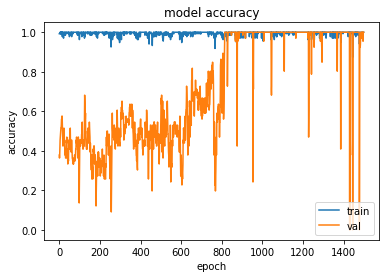

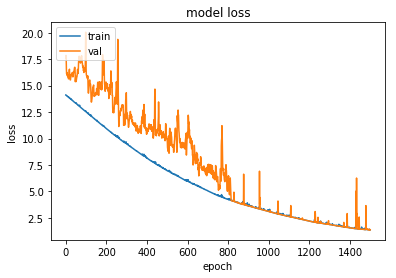

In [0]:
print(d_loss.history.keys())
# summarize history for accuracy
plt.plot(d_loss.history['acc'])
plt.plot(d_loss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(d_loss.history['loss'])
plt.plot(d_loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
